# Monte-carlo simulations

Xrmc and xmim-sim are used for simulation. The sample coordinate system is defined so that the beam travels along the Y-axis, the Z-axis points upwards and the X-axis is parallel with the synchrotron plane, pointing to the left when looking upstream. The detector reference frame (before transformation) is defined so that the Z-axis points upstream, the X-axis (detector image rows) points upwards and the Y-axis (detector image columns) points to the right when looking upstream.

Units are cm (distance), keV (energy) and seconds (time) unless noted otherwise.

In [10]:
import sys
sys.path.insert(1,'/data/id21/inhouse/wout/dev/SpectroCrunchDev/fluxnorm')

from spectrocrunch.simulation.xrmc import XrmcWorldBuilder, loadxrmcresult, showxrmcresult
from spectrocrunch.io import localfs
import numpy as np
import matplotlib.pyplot as plt

Define source

In [11]:
def definesource(world, flux=1e9, energy=7.5, distance=42e2, fullfield=False):
    if fullfield:
        beamsize = 100e-4  # cm
    else:
        beamsize = 1e-4  # cm
    world.definesource(flux=flux, energy=energy, distance=distance, beamsize=beamsize)

Define sample based on projected beam size

In [12]:
def definesample(world, thickness=None, materials=None, fullfield=False):
    projbeamsizesample = 2 * (world.source.distance) * np.tan(world.source.divergence)
    assert world.source.beamsize == projbeamsizesample

    world.removesample()
    if thickness is None or materials is None:
        thickness = [10e-4, 20e-4]
        materials = ['hematite', 'calcite']
    if fullfield:
        # Make sure the entire sample is in the beam footprint
        size = projbeamsizesample/2.
    else:
        # Make sure the sample is larger than the beam footprint
        size = projbeamsizesample*10
    nlayers = len(thickness)
    dxs = [size]*nlayers
    dys = [size]*nlayers
    oxs = [0]*nlayers
    oys = [0]*nlayers
    dxs[0] = 3*size/4.
    dys[0] = size/4.
    oxs[0] = (size-dxs[0])/2.
    oys[0] = 0#-(size-dys[0])/2.
    for t, material, dx, dy, ox, oy in zip(thickness, materials, dxs, dys, oxs, oys):
        world.addcompoundfromname(material)
        world.addlayer(thickness=t, dhor=dx, dvert=dy, ohor=ox, overt=oy, material=material)

Function to run the experiment

In [13]:
def run(world, interactions, simulate=True, plot=True, ylog=False):
    path = localfs.Path(world.main.path)
    if simulate:
        path.remove(recursive=True)
        world.finalize(interactions=interactions)
        if not world.simulate():
            #path.ls(recursive=True)
            raise RuntimeError('Simulation failed')
    else:
        world.finalize(interactions=interactions)
    #if plot:
    #    path.ls(recursive=True)
    data, info = loadxrmcresult(world.detector.outpath, world.detector.name)
    if plot:
        #info.pop('xenergy') # in case you want channels
        showxrmcresult(data, ylog=ylog, **info)
    return data, info

## Imaging

In [14]:
def addpco(world, multiplicity=10):
    forcedetect = True
    poissonnoise = False
    distance = 5  # cm
    shift = 0.002, 0.002  # cm
    angle = np.arctan2(shift, distance)*180/np.pi  # deg
    ebinsize = 5e-3
    n = 128
    projbeamsizetrans = 2 * (world.source.distance + distance) * np.tan(world.source.divergence)
    pixelsize = projbeamsizetrans/n  # beam fits exactly in detector (when angle=[0,0])
    world.addareadetector(distance=distance,
                          pixelsize=(pixelsize, pixelsize), dims=(n, n),
                          orientation_inplane=0, orientation_outplane=0,
                          ebinsize=ebinsize, poissonnoise=poissonnoise,
                          forcedetect=forcedetect, multiplicity=multiplicity)
    #world.detector.add_outplane_rotationloop(angle[1], 1)
    #world.detector.add_inplane_rotationloop(angle[0], 1)
    world.quadrics.add_inplane_rotationloop(90, 1)
    world.quadrics.add_outplane_rotationloop(90, 1)

Visualize sample in transmission with a wide beam and an area detector. Test sample and detector rotation.

Positive rotation in the synchrotron plane:
- sample moves to the left when looking upstream
- detector moves to the left when looking upstream

Positive rotation out of the synchrotron plane:
- sample moves below the synchrotron plane
- detector moves below the synchrotron plane

This means rotations are defined as change-of-frame (inverse of object transformation).

Data shape: (1, 4, 128, 128, 1500)
Step 0
 Min counts/pixel (for each order): [0.]
 Max counts/pixel (for each order): [77708.14418274]
 Total counts (for each order): [8.50372439e+08]
Step 1
 Min counts/pixel (for each order): [0.]
 Max counts/pixel (for each order): [77708.14418278]
 Total counts (for each order): [8.71656467e+08]
Step 2
 Min counts/pixel (for each order): [0.]
 Max counts/pixel (for each order): [77708.14418278]
 Total counts (for each order): [8.94717589e+08]
Step 3
 Min counts/pixel (for each order): [0.]
 Max counts/pixel (for each order): [77708.14418278]
 Total counts (for each order): [8.71716737e+08]


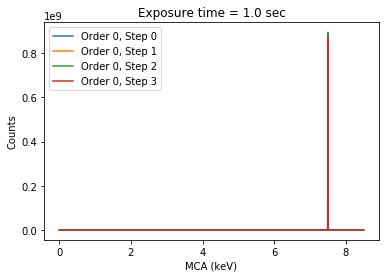

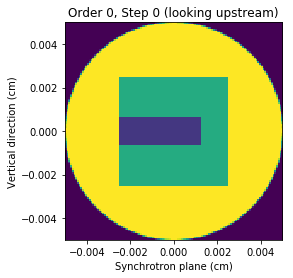

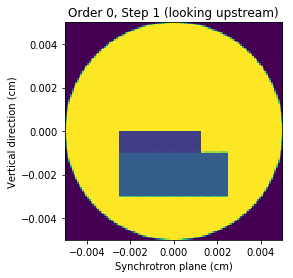

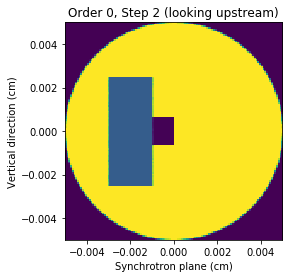

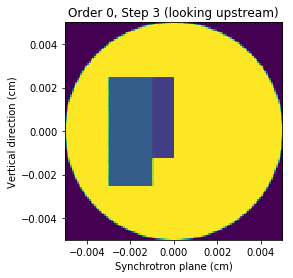

In [15]:
path = r'/data/id21/tmp/xrmctest/imaging'
world = XrmcWorldBuilder(path)
definesource(world, fullfield=True)
definesample(world, fullfield=True)
addpco(world)
data, info = run(world, (10, ), simulate=True)

## XANES

In [16]:
def adddiode(world, angle=0, multiplicity=10):
    forcedetect = False
    poissonnoise = False
    distance = 10  # cm
    activearea = 1  # cm^2
    world.adddiode(distance=distance, activearea=activearea,
                   orientation_inplane=angle, orientation_outplane=0,
                   poissonnoise=poissonnoise, ebinsize=None,
                   forcedetect=forcedetect, multiplicity=multiplicity)

Transmission: diode behind the sample, fluorescence: diode at 110 degrees from the beam (in the synchrotron plane).

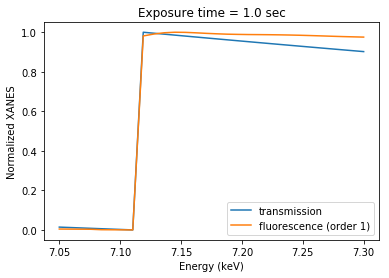

In [17]:
path = r'/data/id21/tmp/xrmctest/xanes'
energy = np.linspace(7.05, 7.3, 30)
world = XrmcWorldBuilder(path)
definesource(world)
definesample(world)
adddiode(world)

for order in range(2):
    # Do not force detection to get the 0-order (transmission).
    if order:
        label = 'fluorescence (order {})'.format(order)
        world.detector.forcedetect = True
        world.detector.orientation_inplane = 110
    else:
        label = 'transmission'
        world.detector.forcedetect = False
        world.detector.orientation_inplane = 0
    multiplicity = (1,) + (1000,)*order
    counts = np.zeros(energy.size)
    for i, en in enumerate(energy):
        world.spectrum.lines[0][0] = en
        data, info = run(world, multiplicity, simulate=True, plot=False)
        counts[i] = np.squeeze(data[order])
    if order==0:
        counts = -np.log(counts)
    counts -= counts.min()
    counts /= counts.max()
    tmp = plt.plot(energy, counts, label=label)
    plt.xlabel('Energy (keV)')
    plt.ylabel('Normalized XANES')
    plt.title('Exposure time = {} sec'.format(info['time']))
tmp = plt.legend()

## XRF

In [18]:
def addsdd(world, angle_start=0, angle_end=0, convoluted=False, multiplicity=10):
    forcedetect = True
    poissonnoise = False
    distance = 5  # cm
    activearea = 0.8  # cm^2
    ebinsize = 5e-3  # keV
    if convoluted:
        world.addelement('Si')
        world.addelement('Be')
        response = {'material': 'Si',
                    'thickness': 100e-4,
                    'windowmaterial': 'Be',
                    'windowthickness': 25e-4,
                    'noise': 0.1,
                    'fano': 0.1}
    else:
        response = {}
    world.addxrfdetector(distance=distance, activearea=activearea,
                         orientation_inplane=angle_start, orientation_outplane=0,
                         ebinsize=ebinsize, poissonnoise=poissonnoise,
                         forcedetect=forcedetect, multiplicity=multiplicity,
                         response=response)
    if angle_start != angle_end:
        angle_step = 1
        angle_nsteps = angle_end-angle_start
        #angle_step, angle_nsteps = angle_nsteps, angle_step
        world.detector.add_inplane_rotationloop(angle_step, angle_nsteps)

### Scattering

Rotate fluorescence detector from 90 to 150 degrees (in plane of synchrotron).

In [19]:
path = r'/data/id21/tmp/xrmctest/xrf'
world = XrmcWorldBuilder(path)
energy = 7.5
angle_start = 90
angle_end = 150
definesource(world, energy=energy)
definesample(world,
             thickness = [30e-4, 100e-4],
             materials = ['hematite', 'calcite'])
addsdd(world, multiplicity=10, angle_start=angle_start,
       angle_end=angle_end, convoluted=False)
data, info = run(world, (1, 10000, ), simulate=True,
                 ylog=True, plot=False)

Plot evolution of elastic scattering peak

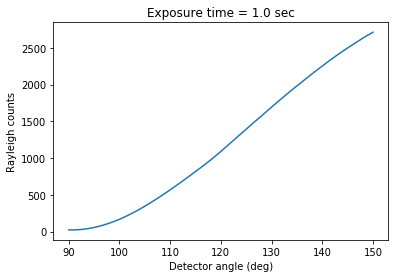

In [20]:
idx = np.argmin(np.abs(info['xenergy']-energy))
y0, y1 = data[..., 0, 0, idx-5:idx+5].sum(axis=-1)
x = np.linspace(angle_start, angle_end, y1.size)
tmp = plt.plot(x, y1)
plt.xlabel('Detector angle (deg)')
plt.ylabel('Rayleigh counts')
tmp = plt.title('Exposure time = {} sec'.format(info['time']))

### Detection limits

Data shape: (2, 1, 1, 1, 1500)
Step 0
 Min counts/pixel (for each order): [0. 0.]
 Max counts/pixel (for each order): [    0.         14068.39534948]
 Total counts (for each order): [     0.         480133.86605126]


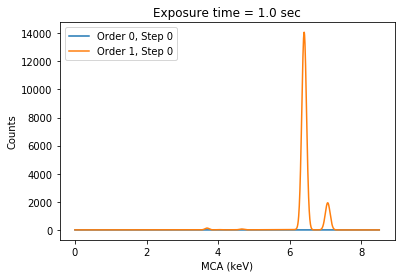

In [21]:
path = r'/data/id21/tmp/xrmctest/xrf'
world = XrmcWorldBuilder(path)
energy = 7.5
angle = 90
definesource(world, energy=energy)
definesample(world,
             thickness = [30e-4, 100e-4],
             materials = ['hematite', 'calcite'])
addsdd(world, multiplicity=10, angle_start=angle,
       angle_end=angle, convoluted=True)
data, info = run(world, (1, 10000, ), simulate=True,
                 ylog=False, plot=True)

In [22]:
from spectrocrunch.detectors import xrf as xrfdetectors
from spectrocrunch.geometries import xrf as xrfgeometries
from spectrocrunch.sources import xray as xraysources

source = xraysources.factory("synchrotron")
detector = xrfdetectors.factory("leia")
geometry = xrfgeometries.factory("sxm120",detectorposition=-20.,detector=detector,source=source)

In [23]:
from spectrocrunch.materials import multilayer
from spectrocrunch.materials import compoundfromname
c1 = compoundfromname.compoundfromname('hematite')
c2 = compoundfromname.compoundfromname('calcite')
sample = multilayer.Multilayer(material=[c1,c2],thickness=[30e-4, 100e-4],geometry = geometry)

  File "/sware/exp/spectrocrunch/2019xrmc_debian8/venv/local/lib/python2.7/site-packages/silx/gui/qt/_qt.py", line 96, in <module>
    since_version='0.9.0')


In [24]:
counts = data[1, 0, 0, 0, :]